# Data preparation

In [1]:
library(DESeq2)
library(ggplot2)
library(pheatmap)
library(dplyr)
library(tidyverse)
library(reshape2)
library(ggrepel)
library(data.table)

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, saveRDS, setdiff, table,
    tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following object is masked from 'package:utils':

    findMatches


The following objects are masked from 'package:base':

    I, expand.grid, unname


Loading required package: IRanges

Loading required package: GenomicRanges

Loading required package: GenomeInfoDb



In [2]:
library(RColorBrewer)

## Set a color-blind friendly palette
heat_colors <- rev(brewer.pal(11, "RdBu"))
heat_colors

[1] "#053061" "#2166AC" "#4393C3" "#92C5DE" "#D1E5F0" "#F7F7F7" "#FDDBC7"
 [8] "#F4A582" "#D6604D" "#B2182B" "#67001F"

In [3]:
# load dds object
dds <- readRDS("data/dds.rds")
dds

class: DESeqDataSet 
dim: 19788 6 
metadata(1): version
assays(4): counts mu H cooks
rownames(19788): ENSG000002272324 ENSG000002376835 ... ENSG000002101952
  ENSG000002101962
rowData names(22): baseMean baseVar ... deviance maxCooks
colnames(6): X_filesTien_Cont1_S25sorted X_filesTien_Cont2_S26sorted
  ... X_filesTien_Zn2_S29sorted X_filesTien_Zn3_S30sorted
colData names(2): condition sizeFactor

# Visualization of Differential Expression Genes

In this section, we will generate some key data tables and use a different visualization techniques to explore our results, including:
- Table of results for all genes
- Table of results for significant genes (adjusted p-value < 0.05)
- Scatterplot of normalized expression of top 20 most significant genes
- Heatmap of all significant genes
- Volcano plot of results for all genes

In [4]:
# read results from file
res_tbl <- read.csv("data/E_vs_C_all_genes.csv", row.names = 1)
res_tbl <- res_tbl %>%
  data.frame() %>%
  rownames_to_column(var = "gene") %>%
  as_tibble() %>%
  arrange(padj)

head(res_tbl)

gene,baseMean,log2FoldChange,lfcSE,pvalue,padj
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSG000002100822,906077.336,2.318742,0.02474128,0.000000e+00,0.000000e+00
ENSG000001987862,299123.224,1.114936,0.02891809,0.000000e+00,0.000000e+00
ENSG000002101962,3257.341,1.950824,0.05312225,1.752506e-297,8.863589e-294
ENSG000001988992,118644.016,-1.109477,0.03023091,4.815037e-296,1.826464e-292
ENSG000002710431,2613.242,1.981360,0.05512599,9.551661e-285,2.898547e-281
ENSG000002282531,43925.514,-1.332115,0.03969099,2.658435e-248,6.722740e-245


## Table of results for significant genes

Filter our table to extract only the significant genes using a p-adjusted threshold of `0.05`:

The `arrange` function sorts the rows of the filtered data frame (sig_res) in ascending order based on the padj column. Rows with smaller padj values appear first.

In [5]:
# Set thresholds
padj_cutoff <- 0.05

# records before
nrow_before <- nrow(res_tbl)

# Subset the significant results
sig_res <- dplyr::filter(res_tbl, padj < padj_cutoff) %>%
  dplyr::arrange(padj)

# records after
nrow_after <- nrow(sig_res)

# print the number of significant results
cat("Total records:", nrow_before, "\n")
cat("Number of significant results:", nrow_after, "\n")
cat("Percentage of significant results:", nrow_after / nrow_before * 100, "%\n")

Total records: 19788 
Number of significant results: 3028 
Percentage of significant results: 15.3022 %


In [6]:
# Write significant results to the "data/" directory
condition <- factor(c("C", "C", "C", "E", "E", "E"))

save_path <- file.path(
  "data",
  paste0(levels(condition)[2], "_vs_", levels(condition)[1],
         "_signif_genes.csv")
)
write.csv(res_tbl,
          file = save_path,
          quote = FALSE,
          row.names = FALSE)

## Fold change

We may also be interested in determining the total number of significantly upregulated or downregulated genes above a certain fold change threshold (for example log2 fold change (in absolute value) >0.58, which corresponds to a ~50% increase (or ~30% decrease) in gene expression.

The main reasons for calculating **log fold change** in DEG analysis are:

1. **Normalization of Data**: Log transformation helps normalize the data, especially when there are large differences in gene expression. Fold change values can vary dramatically between genes (e.g., a gene with fold change 2 might be considered significant, but 10,000 fold change would be a huge outlier).
   
2. **Symmetry**: Log fold change (typically log2) ensures that the scale is symmetric. A 2-fold upregulation (FC = 2) and a 2-fold downregulation (FC = 0.5) will both result in a log fold change of +1 and -1, respectively. This symmetry makes it easier to interpret upregulations and downregulations.
   
3. **Handling Small and Large Changes**: The log scale compresses the range of values, which allows both small and large changes to be analyzed in a comparable manner. For example, a fold change of 10,000 becomes a manageable value when transformed into a log scale (log2(10000) ≈ 13.29).
   
4. **Statistical Analysis**: Log-transformed data are more likely to conform to the assumptions of statistical tests (e.g., normality and variance homogeneity), making the results more reliable.

In summary, **log fold change** is used to make gene expression changes more interpretable, stable, and statistically robust, particularly when working with wide-ranging data across different genes or conditions.

In [8]:
# Set thresholds
log2fc_cutoff <- 0.58

# Count significantly up/down genes above threshold
n_sig_up <- dplyr::filter(sig_res, log2FoldChange >= log2fc_cutoff) %>%
  nrow()
n_sig_dn <- dplyr::filter(sig_res, log2FoldChange <= -log2fc_cutoff) %>%
  nrow()

# print the number of significantly up/down genes
cat("Number of significantly up-regulated genes:", n_sig_up, "\n")
cat("Number of significantly down-regulated genes:", n_sig_dn, "\n")  

Number of significantly up-regulated genes: 273 
Number of significantly down-regulated genes: 197 


## Scatterplot of top 20 most significant genes

In [13]:
## Extract normalized counts from dds object
normalized_counts <- counts(dds, normalized = TRUE)

## Extract top 20 DEG from resLFC (make sure to order by padj)
top20_sig_genes <- sig_res %>%
  dplyr::arrange(padj) %>%
  dplyr::pull(gene) %>%
  head(n = 20)

## Extract matching normalized count values from matrix
cond_matched_counts <- rownames(normalized_counts) %in% top20_sig_genes
top20_sig_counts <- normalized_counts[cond_matched_counts, ]
top20_sig_counts

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
ENSG000002485271,35722.40704,38483.78399,40390.84553,20334.5923,19608.0362,19187.8581
ENSG000001743075,952.35793,932.09123,832.12277,3969.7872,3757.3091,3522.3684
ENSG000001593885,98.82960,96.98059,126.28291,721.1090,730.4276,680.3415
ENSG000002690282,844.54383,776.51820,838.84505,3480.7266,3210.9314,3057.3601
ENSG0000011401910,808.60579,965.76505,1001.62037,2890.1095,2849.2447,2696.3057
ENSG000002710431,1105.09458,1070.15388,1024.18804,4190.4885,4145.2887,4144.2358
ENSG000002476272,4950.46436,5544.05708,5821.97841,1560.2279,1478.1699,1295.7118
ENSG000001247629,161.72116,160.28736,161.33482,980.9578,943.9766,956.9333
ENSG000001350469,242.58174,176.45080,180.54135,1269.7418,1223.5784,1120.2895
ENSG0000018102613,3324.26826,3378.15723,3439.40877,6151.8368,6007.5904,6068.3121


In [14]:
## Convert wide matrix to long data frame for ggplot2
top20_sig_df <- data.frame(top20_sig_counts)
top20_sig_df$gene <- rownames(top20_sig_counts)
top20_sig_df

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG000002485271,35722.40704,38483.78399,40390.84553,20334.5923,19608.0362,19187.8581,ENSG000002485271
ENSG000001743075,952.35793,932.09123,832.12277,3969.7872,3757.3091,3522.3684,ENSG000001743075
ENSG000001593885,98.82960,96.98059,126.28291,721.1090,730.4276,680.3415,ENSG000001593885
ENSG000002690282,844.54383,776.51820,838.84505,3480.7266,3210.9314,3057.3601,ENSG000002690282
ENSG0000011401910,808.60579,965.76505,1001.62037,2890.1095,2849.2447,2696.3057,ENSG0000011401910
ENSG000002710431,1105.09458,1070.15388,1024.18804,4190.4885,4145.2887,4144.2358,ENSG000002710431
ENSG000002476272,4950.46436,5544.05708,5821.97841,1560.2279,1478.1699,1295.7118,ENSG000002476272
ENSG000001247629,161.72116,160.28736,161.33482,980.9578,943.9766,956.9333,ENSG000001247629
ENSG000001350469,242.58174,176.45080,180.54135,1269.7418,1223.5784,1120.2895,ENSG000001350469


- `id.vars = c("gene")`: Specifies that the column `gene` should remain as is (it’s the identifier variable and will not be melted).
- `variable.name = "sample_id"`: Renames the column containing the variable names (e.g., sample columns in the wide format) to `sample_id`.

In [15]:
top20_sig_df <- melt(setDT(top20_sig_df),
                     id.vars = c("gene"),
                     variable.name = "sample_id") %>%
  data.frame()
head(top20_sig_df)

,gene,sample_id,value
,<chr>,<fct>,<dbl>
1,ENSG000002485271,X_filesTien_Cont1_S25sorted,35722.4070
2,ENSG000001743075,X_filesTien_Cont1_S25sorted,952.3579
3,ENSG000001593885,X_filesTien_Cont1_S25sorted,98.8296
4,ENSG000002690282,X_filesTien_Cont1_S25sorted,844.5438
5,ENSG0000011401910,X_filesTien_Cont1_S25sorted,808.6058
6,ENSG000002710431,X_filesTien_Cont1_S25sorted,1105.0946


In [16]:
head(counts(dds))

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
ENSG000002272324,34,531,758,632,558,496
ENSG000002376835,5,60,92,108,87,63
ENSG000002418602,0,7,16,13,17,15
ENSG000002284634,0,4,5,33,6,10
ENSG000002370947,2,17,30,21,25,16
ENSG000002259721,7,202,332,831,648,630


In [17]:
colData(dds)

DataFrame with 6 rows and 2 columns
                            condition sizeFactor
                             <factor>  <numeric>
X_filesTien_Cont1_S25sorted         C   0.111303
X_filesTien_Cont2_S26sorted         C   1.484833
X_filesTien_Cont3_S27sorted         C   2.082625
X_filesTien_Zn1_S28sorted           E   1.762563
X_filesTien_Zn2_S29sorted           E   1.559361
X_filesTien_Zn3_S30sorted           E   1.077400

In [18]:
rownames(colData(dds))

[1] "X_filesTien_Cont1_S25sorted" "X_filesTien_Cont2_S26sorted"
[3] "X_filesTien_Cont3_S27sorted" "X_filesTien_Zn1_S28sorted"  
[5] "X_filesTien_Zn2_S29sorted"   "X_filesTien_Zn3_S30sorted"

In [19]:
## Create the sample_id column
colData(dds)$sample_id <- rownames(colData(dds))

## Join counts data frame with metadata
top20_sig_df <- merge(
  top20_sig_df,
  as.data.frame(colData(dds)),
  by = "sample_id",
  all.x = TRUE
)
head(top20_sig_df)

,sample_id,gene,value,condition,sizeFactor
,<fct>,<chr>,<dbl>,<fct>,<dbl>
1,X_filesTien_Cont1_S25sorted,ENSG000002485271,35722.4070,C,0.1113027
2,X_filesTien_Cont1_S25sorted,ENSG000001743075,952.3579,C,0.1113027
3,X_filesTien_Cont1_S25sorted,ENSG000001593885,98.8296,C,0.1113027
4,X_filesTien_Cont1_S25sorted,ENSG000002690282,844.5438,C,0.1113027
5,X_filesTien_Cont1_S25sorted,ENSG0000011401910,808.6058,C,0.1113027
6,X_filesTien_Cont1_S25sorted,ENSG000002710431,1105.0946,C,0.1113027


**Aesthetic** mappings describe how variables in the data are mapped
 to visual properties (aesthetics) of geoms. Aesthetic mappings can
 be set in ‘ggplot()’ and in individual layers.

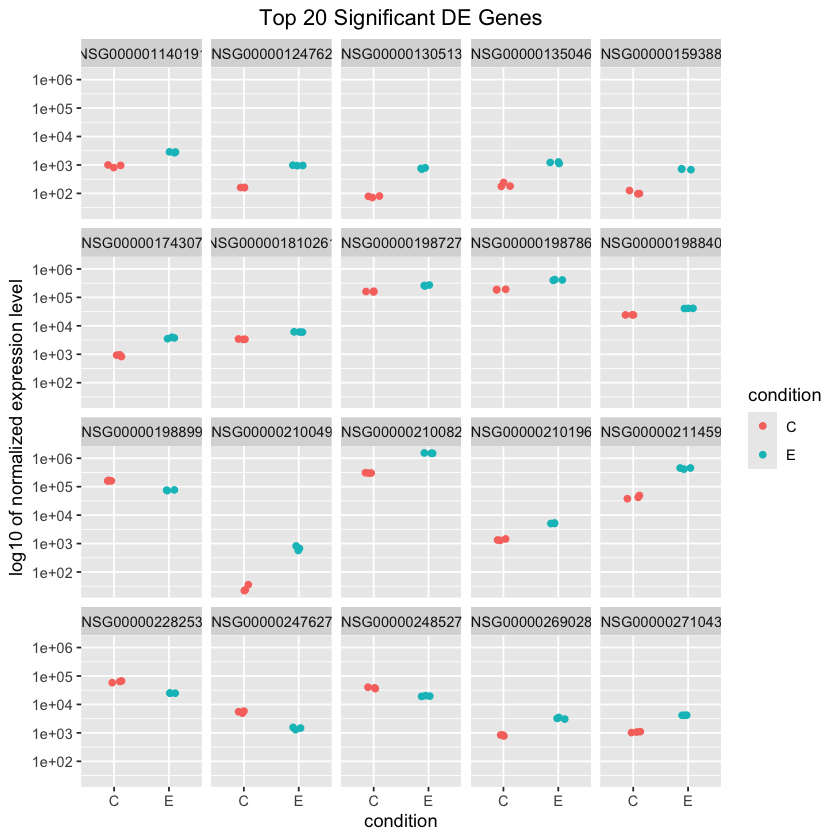

In [20]:
## Generate plot
# Initializes the plot with the dataset top20_sig_df and specifies the aesthetics (the mapping of data to plot elements).
ggplot(top20_sig_df, aes(y = value, x = condition, col = condition)) +

# Adds jittered points (scatterplot with slight random horizontal offsets) to avoid overlapping of points.
geom_jitter(height = 0, width = 0.15) +

# Transforms the y-axis to a log10 scale, making it easier to visualize data with large variations in magnitude (e.g., gene expression levels).
scale_y_continuous(trans = 'log10') +

ylab("log10 of normalized expression level") +
xlab("condition") +
ggtitle("Top 20 Significant DE Genes") +
theme(plot.title = element_text(hjust = 0.5)) +
facet_wrap(~ gene)

## Heatmap of all significant genes

In [21]:
## Extract normalized counts for significant genes only
sig_counts <- normalized_counts[rownames(normalized_counts) %in% sig_res$gene, ]
nrow(sig_counts)
head(sig_counts)

[1] 3028

,X_filesTien_Cont1_S25sorted,X_filesTien_Cont2_S26sorted,X_filesTien_Cont3_S27sorted,X_filesTien_Zn1_S28sorted,X_filesTien_Zn2_S29sorted,X_filesTien_Zn3_S30sorted
ENSG000002259721,62.89156,136.0422,159.4142,471.4725,415.55493,584.74099
ENSG000002256301,15040.06775,15312.8311,17664.7228,21101.0897,20118.50183,30465.00583
ENSG000002293441,431.25642,526.6585,418.7023,332.4704,368.74087,325.78427
ENSG000002404091,107.81411,135.3687,137.8068,51.0620,46.17277,38.05457
ENSG000002485271,35722.40704,38483.7840,40390.8455,20334.5923,19608.03621,19187.85807
ENSG000001987445,260.55076,344.8199,325.0705,121.4141,149.42021,155.00277


In [22]:
colData(dds)$sample_id <- as.factor(colData(dds)$sample_id)
colData(dds)

DataFrame with 6 rows and 3 columns
                            condition sizeFactor                   sample_id
                             <factor>  <numeric>                    <factor>
X_filesTien_Cont1_S25sorted         C   0.111303 X_filesTien_Cont1_S25sorted
X_filesTien_Cont2_S26sorted         C   1.484833 X_filesTien_Cont2_S26sorted
X_filesTien_Cont3_S27sorted         C   2.082625 X_filesTien_Cont3_S27sorted
X_filesTien_Zn1_S28sorted           E   1.762563 X_filesTien_Zn1_S28sorted  
X_filesTien_Zn2_S29sorted           E   1.559361 X_filesTien_Zn2_S29sorted  
X_filesTien_Zn3_S30sorted           E   1.077400 X_filesTien_Zn3_S30sorted  

In [25]:
# Create sample names vector
samples <- c("X_filesTien_Cont1_S25sorted", "X_filesTien_Cont2_S26sorted", "X_filesTien_Cont3_S27sorted", "X_filesTien_Zn1_S28sorted", "X_filesTien_Zn2_S29sorted", "X_filesTien_Zn3_S30sorted")

# Create condition vector
condition <- c("C", "C", "C", "E", "E", "E")

# Create data frame
col_name <- data.frame(
  row.names = samples,
  condition = factor(condition)
)

# View the data frame
col_name

,condition
,<fct>
X_filesTien_Cont1_S25sorted,C
X_filesTien_Cont2_S26sorted,C
X_filesTien_Cont3_S27sorted,C
X_filesTien_Zn1_S28sorted,E
X_filesTien_Zn2_S29sorted,E
X_filesTien_Zn3_S30sorted,E


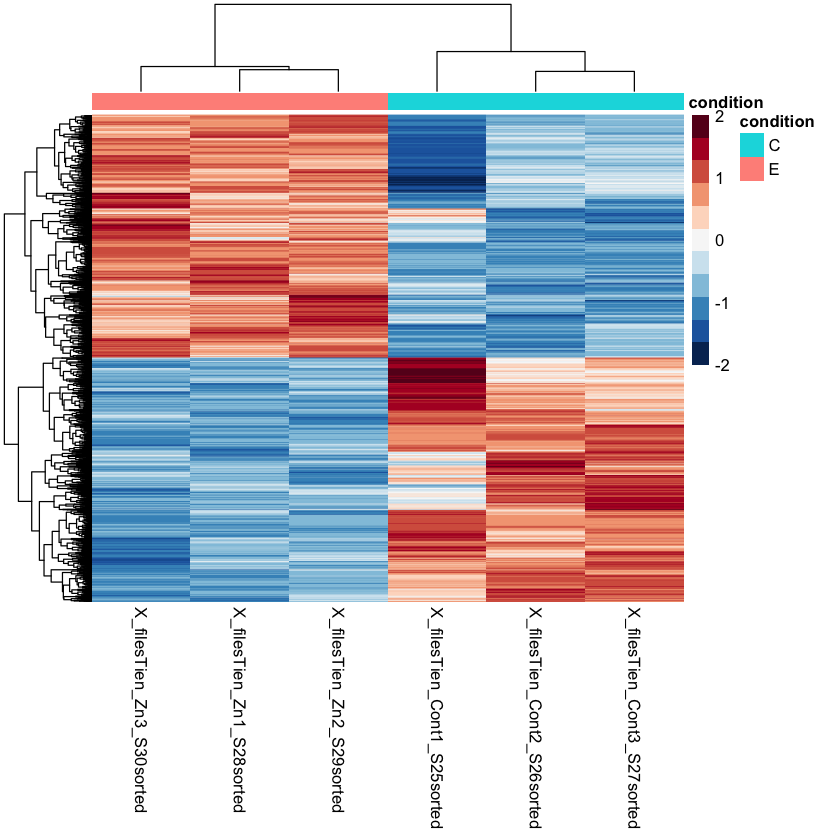

In [26]:
## Run pheatmap using the metadata data frame for the annotation
# The heatmap visualizes the expression values of these genes across samples.
# Groups genes with similar expression patterns together, improving interpretability.
pheatmap(sig_counts,
         color = heat_colors,
         cluster_rows = TRUE,
         show_rownames = FALSE,
         annotation = col_name,
         border_color = NA,
         fontsize = 10,
         scale = "row",
         fontsize_row = 10,
         height = 20)

## Volcano plot

- Filters out rows where the padj (adjusted p-value) is NA. Genes without statistical significance are excluded.
- Adds a new column, threshold, which indicates whether a gene meets the significance criteria:

In [27]:
# Volcano plot
res_table_thres <- res_tbl[!is.na(res_tbl$padj), ] |>
  mutate(threshold = padj < padj_cutoff & abs(log2FoldChange) >= log2fc_cutoff)

head(res_table_thres)
min(log10(res_table_thres$padj))

gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,threshold
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
ENSG000002100822,906077.336,2.318742,0.02474128,0.000000e+00,0.000000e+00,TRUE
ENSG000001987862,299123.224,1.114936,0.02891809,0.000000e+00,0.000000e+00,TRUE
ENSG000002101962,3257.341,1.950824,0.05312225,1.752506e-297,8.863589e-294,TRUE
ENSG000001988992,118644.016,-1.109477,0.03023091,4.815037e-296,1.826464e-292,TRUE
ENSG000002710431,2613.242,1.981360,0.05512599,9.551661e-285,2.898547e-281,TRUE
ENSG000002282531,43925.514,-1.332115,0.03969099,2.658435e-248,6.722740e-245,TRUE


[1] -Inf

In [28]:
# value counts threshold
table(res_table_thres$threshold)


FALSE  TRUE 
14703   470 

In [29]:
# Prepare the data dataframe
data <- res_tbl[!is.na(res_tbl$padj), ]

# Add a sig column
# Default value is "ns" (not significant).
# "Up": Genes with log2FoldChange >= 2 (upregulated) and padj < 0.05.
# "Down": Genes with log2FoldChange <= -2 (downregulated) and padj < 0.05.
data$sig <- "ns"
data$sig[data$log2FoldChange >= 2 & data$padj < 0.05] <- "Up"
data$sig[data$log2FoldChange <= -2 & data$padj < 0.05] <- "Down"

# Extract significant genes
# contains only the significant genes (both upregulated and downregulated).
sigs_df <- data[abs(data$log2FoldChange) >= 2 & data$padj < 0.05, ]
nrow(sigs_df)
head(sigs_df)

[1] 35

gene,baseMean,log2FoldChange,lfcSE,pvalue,padj,sig
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
ENSG000002100822,906077.3363,2.318742,0.02474128,0.000000e+00,0.000000e+00,Up
ENSG000001743075,2327.6728,2.074099,0.06935572,1.770208e-198,3.837053e-195,Up
ENSG000002114592,241983.3942,3.347015,0.11994902,1.749078e-173,2.412615e-170,Up
ENSG000001350469,702.1973,2.706943,0.11501487,8.864564e-125,1.034631e-121,Up
ENSG000001247629,560.8685,2.568374,0.11146761,9.642347e-119,1.045024e-115,Up
ENSG000001305136,416.7204,3.242029,0.14083669,3.434278e-118,3.473887e-115,Up


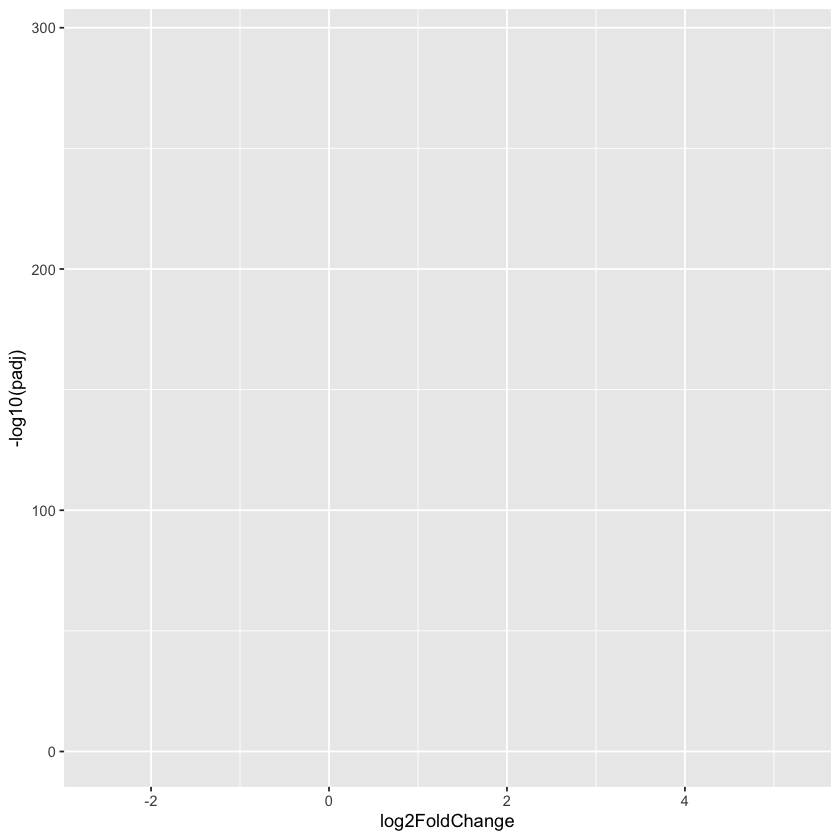

In [30]:
# Initialize the Plot
# X-axis: log2FoldChange (magnitude of gene expression change).
# Y-axis: -log10(padj) (statistical significance,
# with smaller padj values being more significant).
p_vol <- ggplot(data = data,
                aes(x = log2FoldChange,
                    y = -log10(padj)))
p_vol

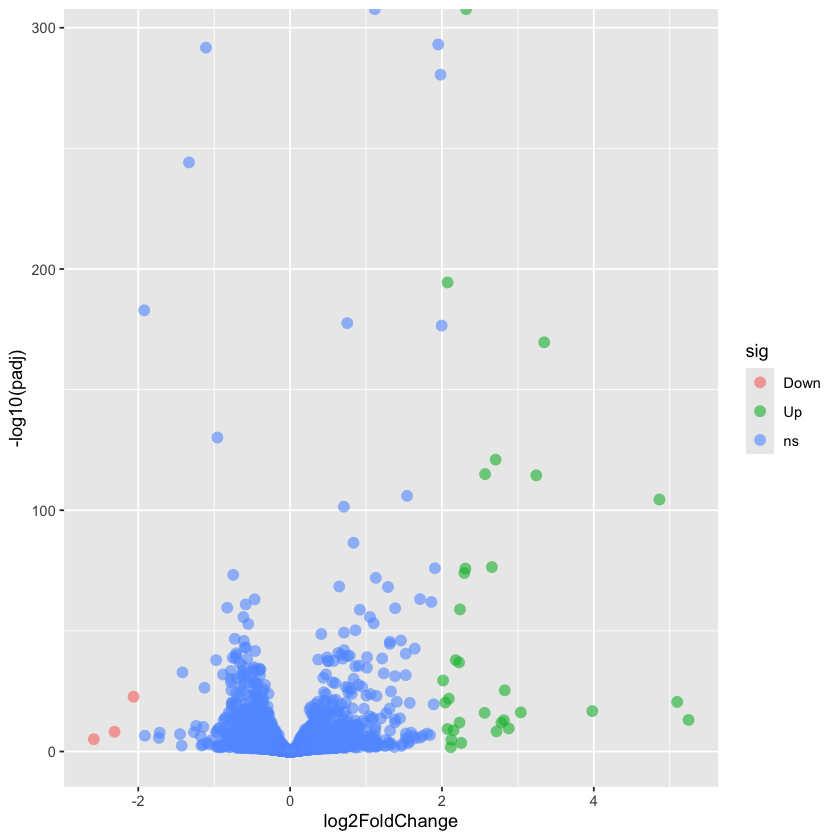

In [31]:
# Add points
p_vol <- p_vol +
  geom_point(aes(colour = sig),
             alpha = 0.6,
             shape = 16,
             size = 3)

p_vol

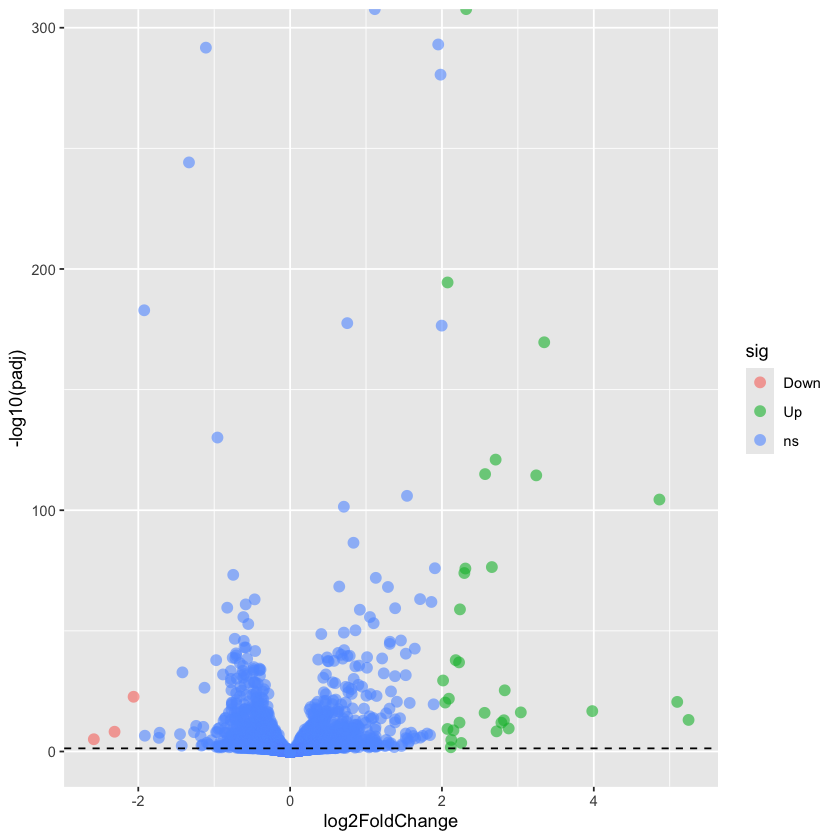

In [32]:
# Add Horizontal Line
# Indicates the statistical significance threshold (e.g., padj = 0.05).
p_vol <- p_vol +
  geom_hline(yintercept = -log10(0.05),
             linetype = "dashed")
p_vol

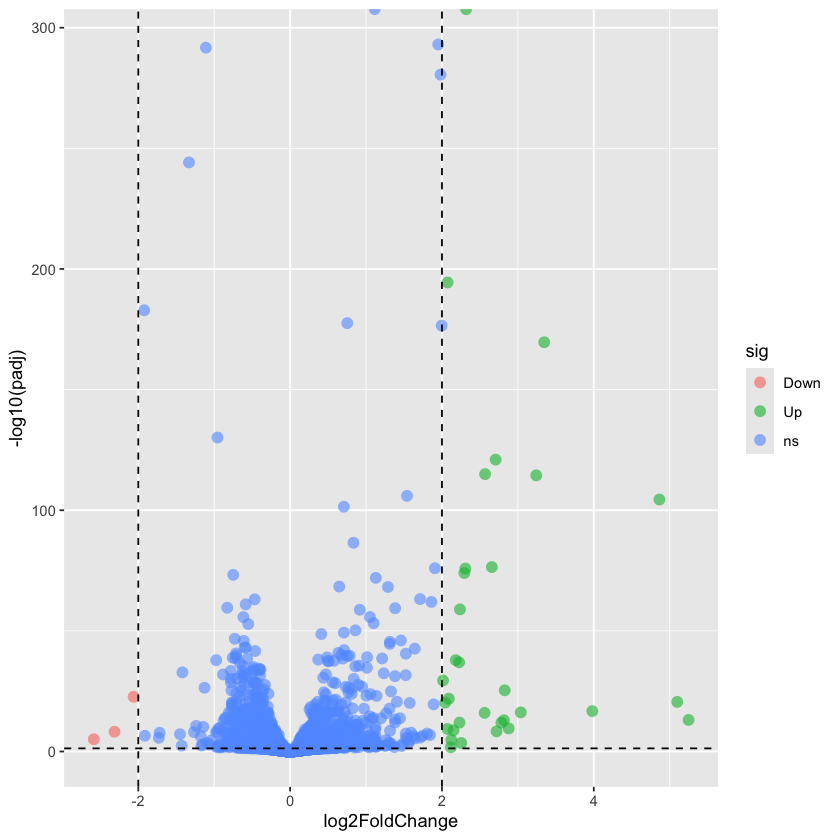

In [33]:
# Add Vertical Lines
# Marks the fold-change thresholds
# (e.g., a 4-fold change in expression corresponds to ±log2(4)).
p_vol <- p_vol +
  geom_vline(xintercept = c(-log2(4), log2(4)),
             linetype = "dashed")
p_vol

Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_label_repel()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_label_repel()`)."
Warning message:
"ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


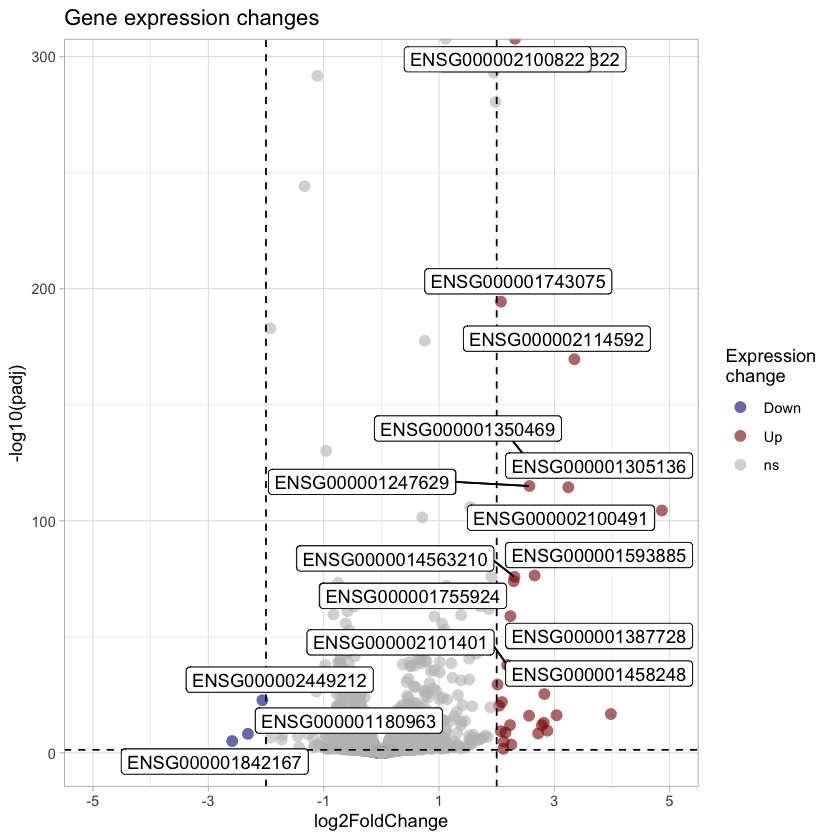

In [37]:
# Add Gene Labels
# Prevents overlapping labels by repelling them away from each other.

p_vol <- p_vol +
  geom_label_repel(data = sigs_df,
                   aes(label = gene),
                   force = 2,
                   nudge_y = 1)
p_vol

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_label_repel()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_label_repel()`)."
Warning message:
"ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


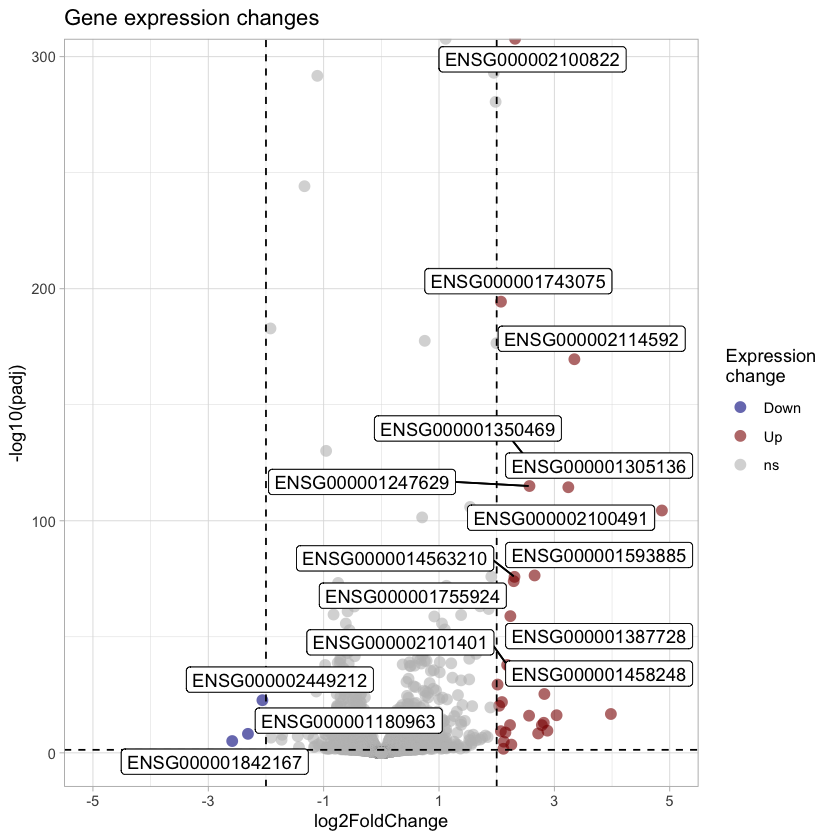

In [38]:
# Customize Colors
p_vol <- p_vol +
  scale_colour_manual(values = c("darkblue", "darkred", "grey"))

# Customize X-Axis
# Sets tick marks at intervals of 2 (e.g., -5, -3, -1, 1, 3, 5).
# Restricts the x-axis range to between -5 and 5.
p_vol <- p_vol +
  scale_x_continuous(breaks = c(seq(-5, 5, 2)),
                     limits = c(-5, 5))
p_vol

Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_label_repel()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_label_repel()`)."
Warning message:
"ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps"
Warning message:
"ggrepel: 17 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


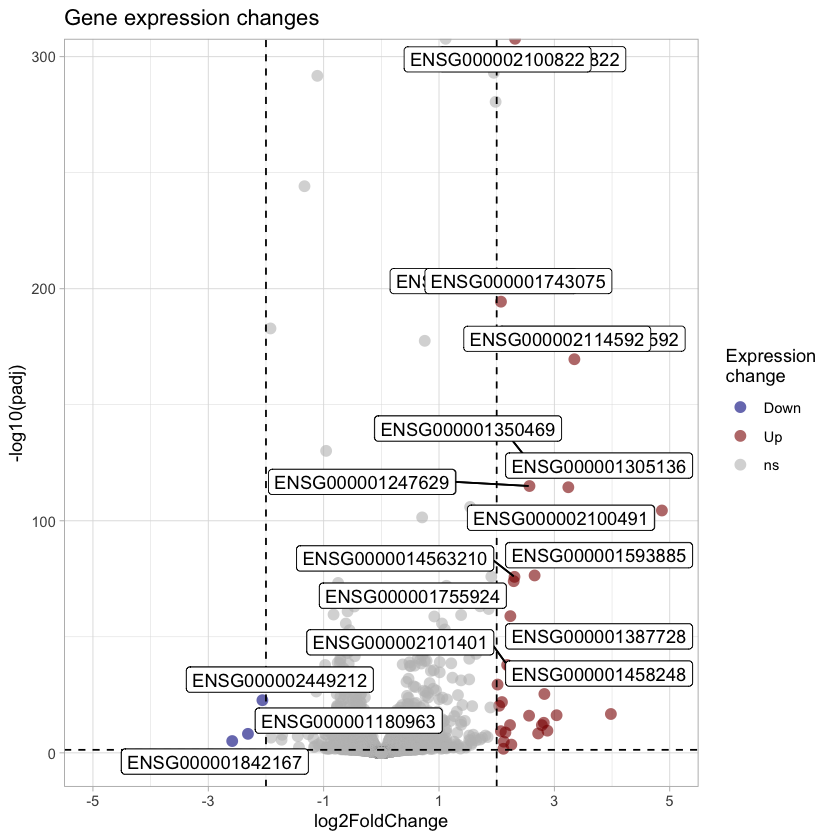

In [39]:
# Add Labels and Title
p_vol <- p_vol +
  labs(title = "Gene expression changes",
       x = "log2FoldChange",
       y = "-log10(padj)",
       colour = "Expression \nchange")

# Apply Theme
p_vol <- p_vol + theme_light()
print(p_vol)

# MA plot

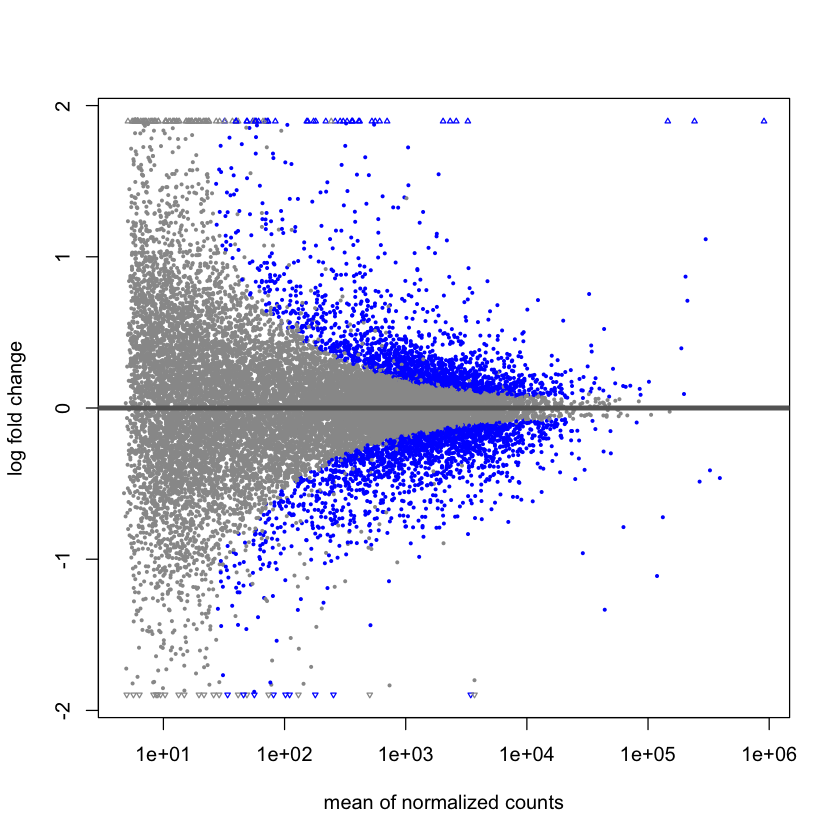

In [40]:
results <- results(dds)

# Filter significant genes
filter_cond <- results$padj < 0.05 & abs(results$log2FoldChange) > 1

# filter NA values
filter_cond <- filter_cond & !is.na(results$padj)
significant_deseq2 <- results[filter_cond, ]

# Basic visualization
plotMA(results)